In [29]:
import pr_utils
from sklearn.decomposition import PCA

def get_pca_dataset(n_components, X_train, X_test):
    # print(X_train.shape)
    
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    
    # print(X_train.shape)
    
    pca = PCA(n_components=n_components)
    X_test_pca = pca.fit_transform(X_test)
    
    return X_train_pca, X_test_pca

In [33]:
X_train, y_train = pr_utils.get_train_dataset_100()
X_test, y_test = pr_utils.get_test_dataset_1000()
X_train_pca, X_test_pca = get_pca_dataset(110, X_train, X_test)

#shapes (1000,105) and (100,2) not aligned: 105 (dim 1) != 100 (dim 0)

print(X_train.shape, X_test.shape)
print(X_train_pca.shape, X_test_pca.shape)

(100, 900) (1000, 900)
(100, 100) (1000, 110)


In [23]:
import numpy as np
from sklearn import metrics
from sklearn.neural_network import MLPClassifier


def tune_layer_size(X_train, y_train, X_test, y_test):
    # layer1_step = 10
    # layer2_step = 5
    # layer1_start = 10
    # layer1_stop = 400
    # layer2_start = 15
    # layer2_stop = 100

    layer1_step = 2
    layer2_step = 2
    layer1_start = 2
    layer1_stop = 60
    layer2_start = 11
    layer2_stop = 60

    results = {}

    # tmp_X_train = []
    # tmp_y_train = []
    # for i in range(3):
    #     x, y = X_train, y_train
    #     tmp_X_train.append(x)
    #     tmp_y_train.append(y)

    for layer2 in range(layer2_start, layer2_stop, layer2_step):
        for layer1 in range(layer1_start, layer1_stop, layer1_step):
            tmp_results = []
            # for ds in zip(tmp_X_train, tmp_y_train):
            mlp = MLPClassifier(hidden_layer_sizes=(layer1, layer2), max_iter=150, alpha=1e-5,
                                solver='lbfgs', tol=1e-4, random_state=1,
                                learning_rate_init=.1)
            # mlp.fit(ds[0], ds[1])
            mlp.fit(X_train, y_train)

            predicted_data = mlp.predict(X_test)
            acc = metrics.accuracy_score(y_test, predicted_data)
            tmp_results.append(acc)

            results[(layer1, layer2)] = np.mean(tmp_results)
        # print("progress", (((layer2 - layer2_start) / layer2_step) + 1) / ((layer2_stop - layer2_start) / layer2_step))

    max_key = max(results.keys(), key=(lambda key: results[key]))
    # print(max_key)
    # print(results.get(max_key))

    return results, max_key, results.get(max_key)

In [35]:
results = {}
X_train, y_train = pr_utils.get_train_dataset_100()
X_test, y_test = pr_utils.get_test_dataset_1000()

for n_components in range(10, X_train.shape[0], 4):
    print("currently processing", n_components, "components")
    X_train_pca, X_test_pca = get_pca_dataset(n_components, X_train, X_test)

    nn_result, max_key, best_performance = tune_layer_size(X_train_pca, y_train, X_test_pca, y_test)

    results[n_components] = best_performance, max_key
    print("result=", best_performance)


max_key = max(results.keys(), key=(lambda key: results[key][0]))

print(max_key, results.get(max_key))

currently processing 10 components


result= 0.387
currently processing 14 components


result= 0.386
currently processing 18 components


result= 0.391
currently processing 22 components


result= 0.363
currently processing 26 components


result= 0.396
currently processing 30 components


result= 0.379
currently processing 34 components


result= 0.385
currently processing 38 components


result= 0.389
currently processing 42 components


result= 0.378
currently processing 46 components


result= 0.395
currently processing 50 components


result= 0.387
currently processing 54 components


result= 0.374
currently processing 58 components


result= 0.378
currently processing 62 components


result= 0.407
currently processing 66 components


result= 0.385
currently processing 70 components


result= 0.397
currently processing 74 components


result= 0.396
currently processing 78 components


result= 0.381
currently processing 82 components


result= 0.391
currently processing 86 components


result= 0.407
currently processing 90 components


result= 0.39
currently processing 94 components


result= 0.373
currently processing 98 components


result= 0.386
86 (0.40699999999999997, (18, 27))


In [45]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def get_raw_pixels(full_data=True):
    df = pd.read_csv('data/processed_nist_data.csv', sep=',', header=None)
    if full_data:
        df = df.as_matrix()
        X, y = df[:, 1:], df[:, 0]
        X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.8, shuffle=True)
    else:
        df = df.sample(frac=1).reset_index(drop=True)  # shuffle data
        df = df.groupby(0)
        df100 = df.apply(lambda x: x.sample(frac=0.01)).as_matrix()
        X_train, y_train = df100[:, 1:], df100[:, 0]
        df1000 = df.apply(lambda x: x.sample(frac=0.1)).as_matrix()
        X_validate, y_validate = df1000[:, 1:], df1000[:, 0]
        
    return X_train, X_validate, y_train, y_validate


def experimentPCA_fulldata(classifier, full_data=True, filename=None, show_results=False, n_comp_auto=False):
    performance = {}
    
    if full_data:
        X_train, X_validate, y_train, y_validate = get_raw_pixels(full_data=True)
    else:
        X_train, X_validate, y_train, y_validate = get_raw_pixels(full_data=False)

    if not n_comp_auto:
        for n_comp in range(1, 30):
            print("processing c=", n_comp)
            pca = PCA(n_components=n_comp)
            classifier.fit(pca.fit_transform(X_train), y_train)
            performance[n_comp] = accuracy_score(y_validate, classifier.predict(pca.transform(X_validate))) * 100
        handle_plot(performance, show_results, filename)
    else:
        pca = PCA()
        pca.fit(X_train)
        variance = pca.explained_variance_
        n_comp = max(np.argwhere(variance > 0.9))[0]
        pca.n_components = n_comp
        classifier.fit(pca.fit_transform(X_train), y_train)
        performance[0] = accuracy_score(y_validate, classifier.predict(pca.transform(X_validate))) * 100

    return performance, n_comp


def handle_plot(performance, show_results, filename):
    fig = plt.figure()
    plt.title('Number of Components Retained vs Performance')
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy (%)')

    plt.plot(performance.keys(), performance.values())
    if show_results:
        plt.show()
    if filename:
        pp = PdfPages("experiment-results/" + filename + ".pdf")
        pp.savefig(fig)
        pp.close()

processing c= 1


processing c= 2


processing c= 3


processing c= 4


processing c= 5


processing c= 6
processing c= 7


processing c= 8


processing c= 9
processing c= 10


processing c= 11
processing c= 12


processing c= 13
processing c= 14


processing c= 15
processing c= 16


processing c= 17
processing c= 18


processing c= 19
processing c= 20


processing c= 21
processing c= 22


processing c= 23
processing c= 24


processing c= 25
processing c= 26


processing c= 27


processing c= 28
processing c= 29


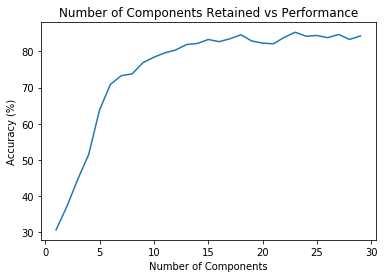

({1: 30.699999999999999,
  2: 37.200000000000003,
  3: 44.700000000000003,
  4: 51.5,
  5: 63.800000000000004,
  6: 70.899999999999991,
  7: 73.299999999999997,
  8: 73.799999999999997,
  9: 76.900000000000006,
  10: 78.400000000000006,
  11: 79.600000000000009,
  12: 80.400000000000006,
  13: 81.899999999999991,
  14: 82.199999999999989,
  15: 83.299999999999997,
  16: 82.699999999999989,
  17: 83.5,
  18: 84.599999999999994,
  19: 82.899999999999991,
  20: 82.299999999999997,
  21: 82.099999999999994,
  22: 83.899999999999991,
  23: 85.299999999999997,
  24: 84.200000000000003,
  25: 84.399999999999991,
  26: 83.799999999999997,
  27: 84.700000000000003,
  28: 83.299999999999997,
  29: 84.299999999999997},
 29)

In [46]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
import pr_utils

mlp = MLPClassifier(hidden_layer_sizes=(330, 85), max_iter=150, alpha=1e-5,
                    solver='lbfgs', tol=1e-4, random_state=1,
                    learning_rate_init=.1)

experimentPCA_fulldata(mlp, full_data=False, filename="NN_330_85_batch", show_results=True, n_comp_auto=False)